Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           7985100   
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           439296    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dropout (Dropout)           (None, 32)                0     

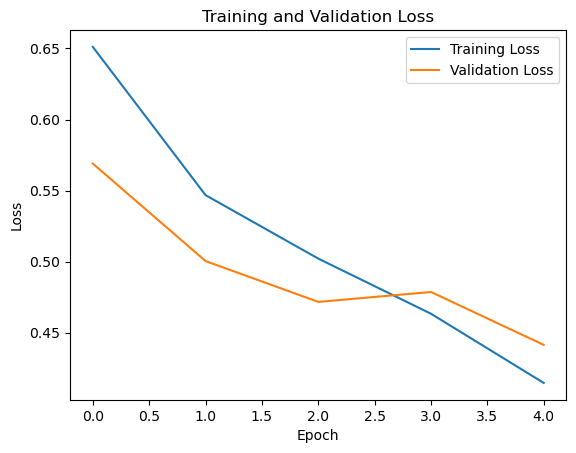

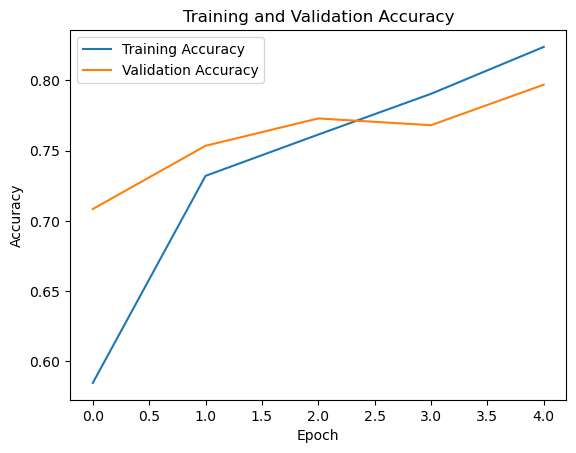

179/179 [==============================] - 10s 52ms/step
LSTM Model Metrics:
Accuracy: 0.7933263452131377
Precision: 0.783982365907421
Recall: 0.7819714181018688
F1 Score: 0.7829756008071913
179/179 [==============================] - 9s 51ms/step - loss: 0.4343 - accuracy: 0.7933
Test Accuracy: 0.7933263182640076


In [12]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import random
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Misspelled Dictionary
mispell_dict = {
    "ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", 
    "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", 
    "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
    "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", 
    "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
    "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
    "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", 
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", 
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", 
    "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
    "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", 
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", 
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
    "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
    "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", 
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
    "wont": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", 
    "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", 
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 
    'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 
    'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
    'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 
    'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 
    'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 
    'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 
    'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
    'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 
    'demonitization': 'demonetization', 'demonetisation': 'demonetization'
}

mispell_dict = {k.lower(): v.lower() for k, v in mispell_dict.items()}


# Function for expanding contractions
def expand_contractions(text):
    def replace(match):
        word = match.group(0)
        return mispell_dict.get(word, word)
    return re.sub(r"\b\w+\b", replace, text)

def preprocessing_text(s):
    s = str(s).lower().strip()
    
    # Map specific symbols to corresponding words
    symbol_mapping = {
        '!': 'exclamation',
        '?': 'question',
        '"': 'quotation'
    }
    for symbol, word in symbol_mapping.items():
        s = s.replace(symbol, f' {word} ')
    
    # Expand contractions
    s = expand_contractions(s)
    
    # Remove all non-alphanumeric characters using regular expression
    s = re.sub(r'[^a-zA-Z0-9\s]', '', s)
    
    # Replace commas with a space
    s = s.replace(',', ' ')
    
    # Other preprocessing steps
    s = re.sub('\n', '', s)
    s = re.sub('[ ]{2,}', ' ', s).strip()
    return s

# Load the data
file_path = 'Sarcasm_Headlines_Dataset_v2.json'

# Load the JSON file into a DataFrame using pandas
headings = pd.read_json(file_path, lines=True)
headings = headings.drop('article_link', axis=1)


# Apply preprocessing_text function
headings['headline'] = headings['headline'].apply(preprocessing_text)


# Define constants
TOTAL_WORDS = min(TOTAL_WORDS, len(tokenizer.word_index) + 1)
MAX_LEN = 50
EMBEDDING_SIZE = 300

# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(headings['headline'], headings['is_sarcastic'], test_size=0.2, random_state=42)

# Tokenize the data and create the embedding matrix
tokenizer = Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(train_data))
train_data = tokenizer.texts_to_sequences(train_data)
test_data = tokenizer.texts_to_sequences(test_data)
train_data = pad_sequences(train_data, maxlen=MAX_LEN)
test_data = pad_sequences(test_data, maxlen=MAX_LEN)

# Load the pre-trained word embeddings (EMBEDDING_FILE remains the same)
EMBEDDING_FILE = 'crawl-300d-2M.vec'

# An embedding matrix is created based on the word index and pre-trained embeddings, 
# which will be used to initialize the embedding layer in the LSTM model.

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((TOTAL_WORDS, EMBEDDING_SIZE))

for word, i in word_index.items():
    if i >= TOTAL_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the LSTM model (The model definition remains the same)
input_layer = Input(shape=(MAX_LEN,))
embedding_layer = Embedding(TOTAL_WORDS, EMBEDDING_SIZE, trainable=False)(input_layer)
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
maxpool_layer = GlobalMaxPool1D()(lstm_layer)
dense_layer_1 = Dense(32, activation="relu")(maxpool_layer)
dropout_1 = Dropout(0.5)(dense_layer_1)
dense_layer_2 = Dense(16, activation="relu")(dropout_1)
dropout_2 = Dropout(0.5)(dense_layer_2)
output_layer = Dense(1, activation="sigmoid")(dropout_2)
model = Model(inputs=input_layer, outputs=output_layer)
# The model is compiled using binary cross-entropy loss and the Adam optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the LSTM model (The training step remains the same)
history = model.fit(train_data, train_labels, batch_size=32, epochs=5, validation_split=0.2)

# Analyze the training history by plotting the loss and accuracy curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Make predictions using the trained LSTM model on the test data
predictions = model.predict(test_data)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Calculate evaluation metrics for the LSTM model
lstm_accuracy = accuracy_score(test_labels, predictions)
lstm_precision = precision_score(test_labels, predictions)
lstm_recall = recall_score(test_labels, predictions)
lstm_f1_score = f1_score(test_labels, predictions)

# Print the evaluation metrics for the LSTM model
print("LSTM Model Metrics:")
print("Accuracy:", lstm_accuracy)
print("Precision:", lstm_precision)
print("Recall:", lstm_recall)
print("F1 Score:", lstm_f1_score)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data, test_labels)

# Print the accuracy
print("Test Accuracy:", accuracy)
